In [23]:
import os 
import pandas as pd
import numpy as np
import subprocess
import glob
import pybedtools as pbt 
from IPython.display import HTML
import seaborn as sns 
import matplotlib.pyplot as plt
pd.set_option('display.min_rows', 100) 
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

pbt.set_bedtools_path('/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/bin/')
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')
os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/jreyna-temp/projects/dchallenge/')

gsizes = 'results/refs/hg19/hg19.chrom.sizes'
res = 5000

# make the directory to save our data
outdir = 'results/main/hichip/summary/'
os.makedirs(outdir, exist_ok=True)
bedpe_cols = ['chrA', 'startA', 'endA', 'chrB', 'startB', 'endB']

## Loading the gene data

In [24]:
# get reference files 
genome_sizes="results/refs/hg19/hg19.chrom.sizes"

# loading the sample sheet
samplesheet = pd.read_table('config/sgl_samplesheets/sgl.samplesheet.tsv')
samplesheet = samplesheet.loc[~samplesheet['eqtl_source'].isna()]

In [25]:
# loading all hichip data
hichip_template = 'results/main/h3k27ac_hichip/{loop_source}/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed'
hichip_data = []
hichip_pbts = {}
curr_id = 0

In [26]:
glob.glob(hichip_template.format(loop_source='*'))

['results/main/h3k27ac_hichip/NK-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/monocyte_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/CD8_T-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/Tfh_memory/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/B-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/Th1-17_memory/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/Th2_memory/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/Treg_memory/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/monocyte_nonclassical_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/main/h3k27ac_hichip/Th17_memory/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed',
 'results/mai

In [27]:
for hichip_fn in glob.glob(hichip_template.format(loop_source='*')):
    
    celltype = hichip_fn.split('/')[3]
    
    if celltype not in ['CD8_T-cell_naive', 'CD4_T-cell_naive', 'monocyte_naive', 'B-cell_naive', 'NK-cell_naive']:
        continue
        
    print(hichip_fn)

    
    # load hichip
    curr_hichip = pd.read_table(hichip_fn)
    curr_hichip['celltype'] = celltype
    curr_hichip['loop.id'] = range(curr_id, curr_id + len(curr_hichip))
    curr_id += len(curr_hichip)
    hichip_data.append(curr_hichip)
    
    # create pbt
    hichip_pbt = pbt.BedTool.from_dataframe(curr_hichip[['chr1', 's1', 'e1', 'chr2', 's2', 'e2', 'loop.id']])
    
    hichip_pbts[celltype] = hichip_pbt

# concat everything together
hichip = pd.concat(hichip_data)

results/main/h3k27ac_hichip/NK-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed
results/main/h3k27ac_hichip/monocyte_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed
results/main/h3k27ac_hichip/CD8_T-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed
results/main/h3k27ac_hichip/B-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed
results/main/h3k27ac_hichip/CD4_T-cell_naive/FitHiChIP_S/FitHiChIP.interactions_FitHiC_Q0.01.bed


In [28]:
celltype_summary = hichip.celltype.value_counts()

In [29]:
celltype_summary = celltype_summary.to_frame()
celltype_summary.columns = ['count']
celltype_summary['cell_type'] = ['NK cells', 'B-cells', 'CD4 T-cells', 'CD8 T-cells', 'Monocytes']
celltype_summary['cell_type_orig'] = celltype_summary.index.tolist()

In [34]:
celltype_summary.sort_index(inplace=True)

In [35]:
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

In [36]:
colors_dict

{'Monocytes': '#B22222',
 'B-cells': '#32CD32',
 'CD4 T-cells': '#00BFFF',
 'CD8 T-cells': '#EE82EE',
 'NK cells': '#FFD700'}

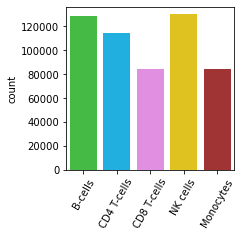

In [37]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x='cell_type', y='count', hue='cell_type', palette=colors_dict, data=celltype_summary, dodge=False)
ax.set_xlabel('')

ax.set_xticklabels(celltype_summary['cell_type'], rotation = 60)
legend = ax.legend_
legend.set_visible(False)

hichip_summary_fn = os.path.join(outdir, 'hichip_summary.svg')
fig.savefig(hichip_summary_fn)